In [1]:
import numpy as np
import os
from pprint import pprint
from sklearn.preprocessing import normalize
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
import pandas as pd
from nltk.tokenize import word_tokenize
import nltk
from nltk.draw.dispersion import dispersion_plot
import matplotlib.pyplot as plt
import networkx as nx
import collections

# make matplotlib inline
%matplotlib inline

/anaconda3/envs/Thesis/lib/python3.7/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [2]:
TV_SHOW = 'Blackish'
OUTPUT_DIR = '../models/'+TV_SHOW
INPUT_DIR = '../output/'

In [3]:
# load the data frame
with open('../output/'+TV_SHOW+'_preprocessed_tweets_with_userid.csv', 'r') as infile:
  df = pd.read_csv(infile, names=['userid', 'tweets'], delimiter='|')
  df['tweets'] = df.tweets.str.replace(r'\W+',' ')

# Convert the tweet_doc into tweet_tokens and remove non_alphanumeric strings in the tokens
df['tweet_tokens'] = df['tweets'].apply(lambda x: x.split())

df.head()

,userid,tweets,tweet_tokens
0,104299103,record tomorrow night blackishabc sept24 till...,"[record, tomorrow, night, blackishabc, sept24,..."
1,370503440,record tomorrow night blackishabc sept24 plea...,"[record, tomorrow, night, blackishabc, sept24,..."
2,862425908,well believe blackishabc premiere tomorrow al...,"[well, believe, blackishabc, premiere, tomorro..."
3,277150329,record tomorrow night blackishabc sept24 yes ...,"[record, tomorrow, night, blackishabc, sept24,..."
4,1413971334,well believe blackishabc premiere tomorrow ri...,"[well, believe, blackishabc, premiere, tomorro..."


In [4]:
len(df.userid.tolist())

945

In [5]:
def plot_graph(G):
    pos = nx.spring_layout(G, k=0.3*1/np.sqrt(len(G.nodes())), iterations=20)
    nx.draw_networkx_nodes(G, pos, node_size = 50)
    #nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True)
    plt.rcParams['figure.figsize'] = [200, 200]
    plt.title("Retweet Network drawn from 200 random nodes", { 'fontsize': 20 })
    plt.axis('off')
    plt.rcParams["figure.figsize"] = (30,30)
    plt.show()
    
def plot_sub_graph(G):
    pass
    
def remove_isolated_nodes(G):
    print(nx.info(G))
    isolated_nodes = list(nx.isolates(G))
    print('\nIsolated nodes: {}\n'.format(len(isolated_nodes)))
    print('removing isolated nodes...\n')
    G.remove_nodes_from(isolated_nodes)
    print(nx.info(G))
    return G

def get_all_degrees(G):
    return sorted(G.degree, key=lambda x: x[1], reverse=True)

def get_all_in_degrees(G):
    return sorted(G.in_degree, key=lambda x: x[1], reverse=True)

def get_degree(node, G):
    return G.degree[node]

def get_in_degree(node, G):
    return G.in_degree[node]

In [6]:
graph = nx.read_graphml(INPUT_DIR+TV_SHOW+'.graphml')
graph = remove_isolated_nodes(graph)

Name: 
Type: DiGraph
Number of nodes: 25671
Number of edges: 33055
Average in degree:   1.2876
Average out degree:   1.2876

Isolated nodes: 5548

removing isolated nodes...

Name: 
Type: DiGraph
Number of nodes: 20123
Number of edges: 33055
Average in degree:   1.6426
Average out degree:   1.6426


Name: 
Type: DiGraph
Number of nodes: 976
Number of edges: 33
Average in degree:   0.0338
Average out degree:   0.0338


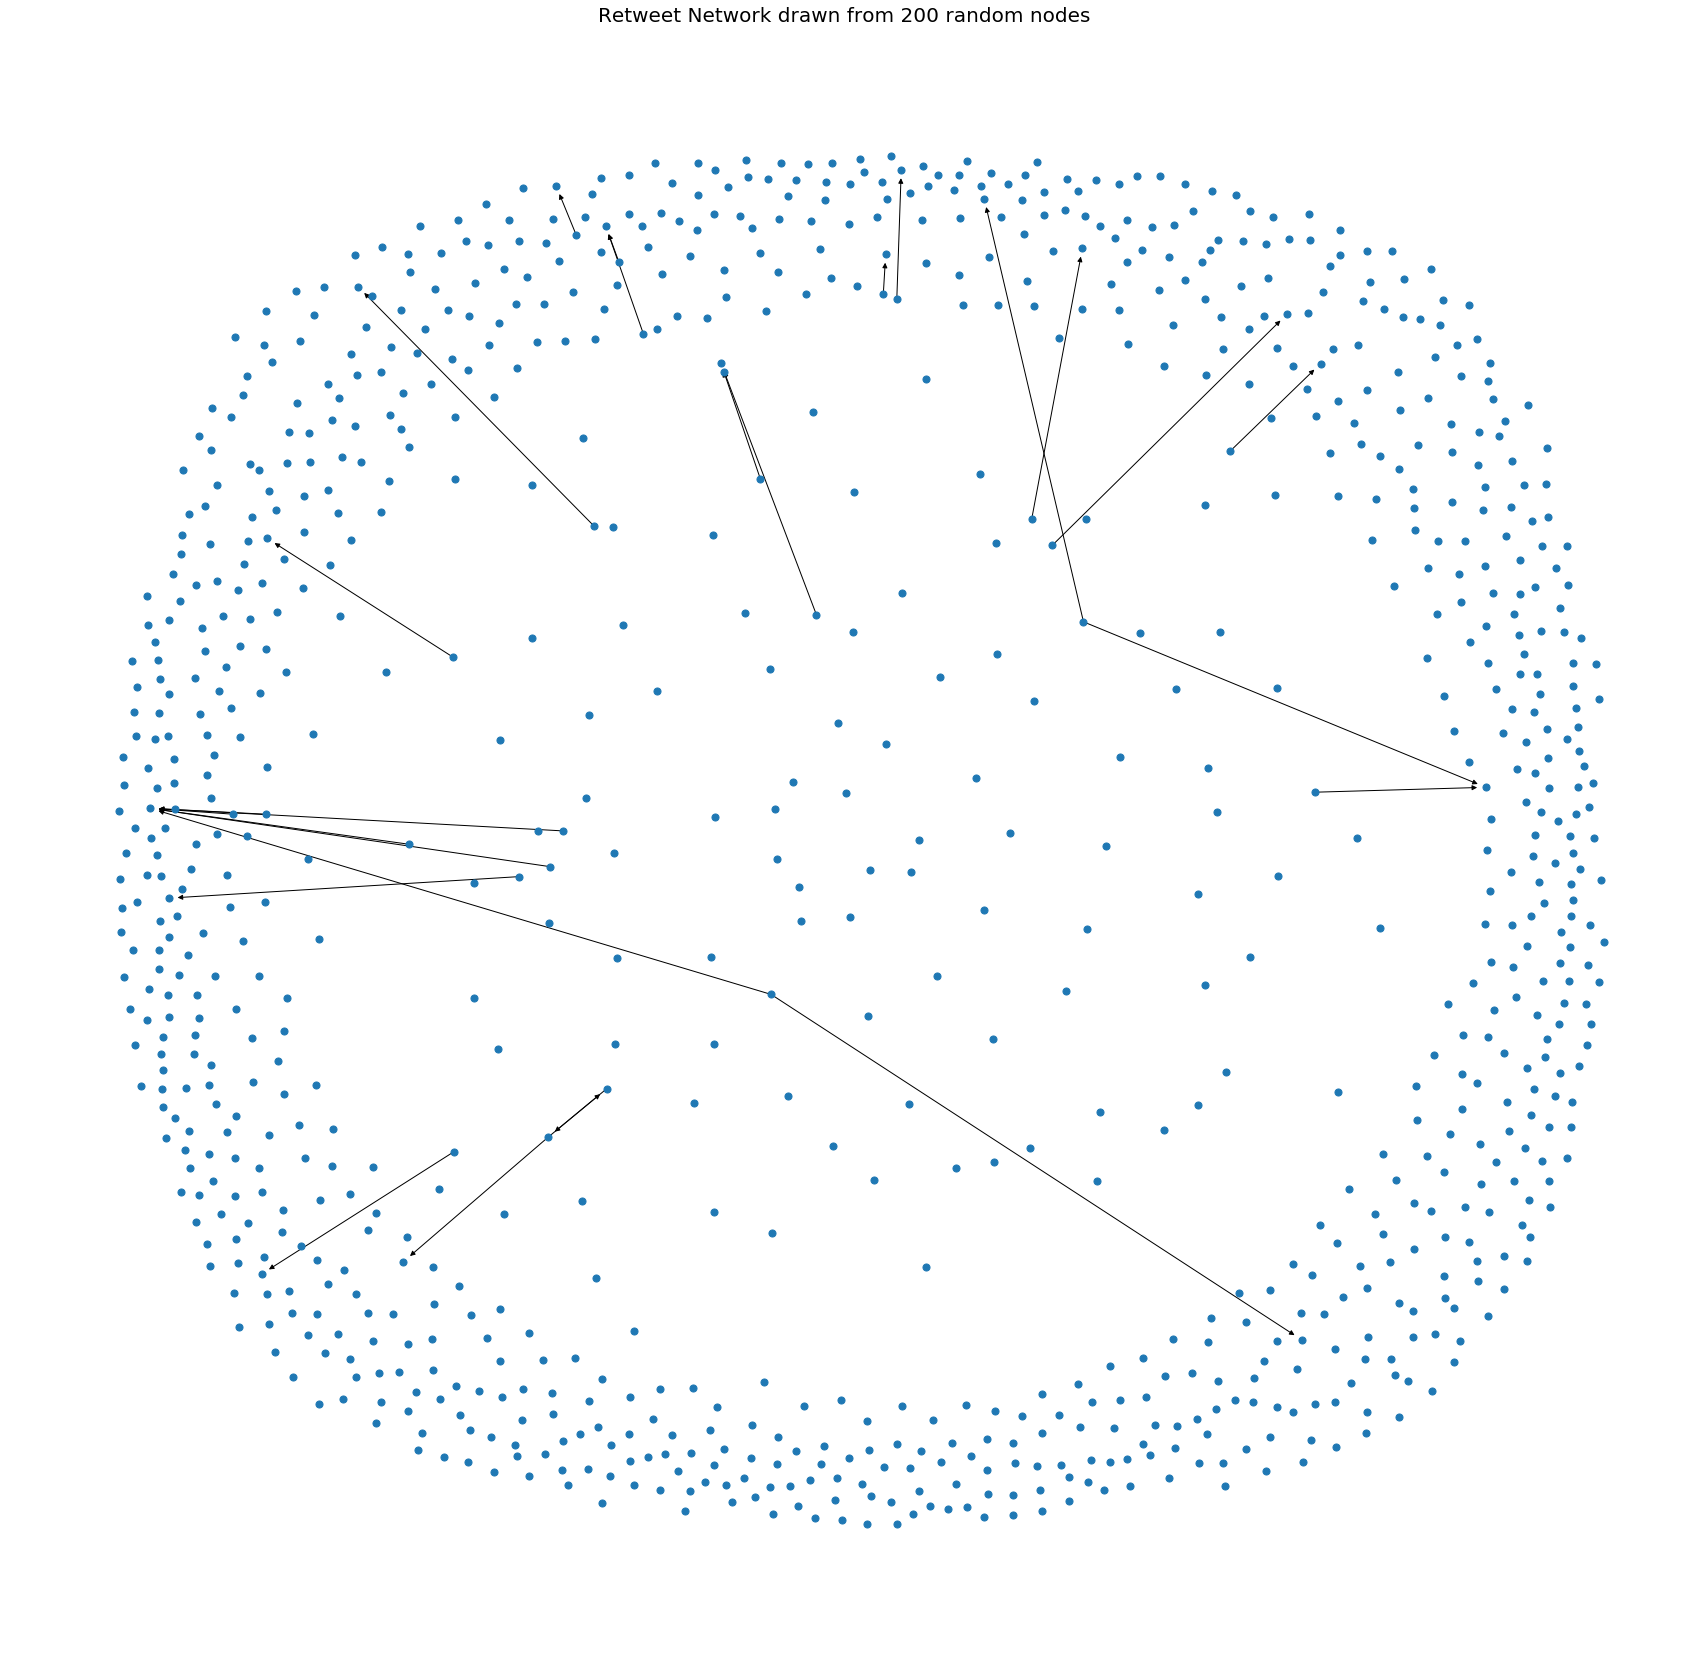

In [12]:
# Create a sub graph with 500 nodes for plotting
np.random.seed(seed=2)
sub_G = graph.subgraph(np.random.choice(graph.nodes, 1000).tolist())
print(nx.info(sub_G))
plot_graph(sub_G)

In [13]:
def create_Directories(path):
  ''' Checks for the directory. If not present creates the directory'''
  try: 
      os.makedirs(path)
  except OSError:
      if not os.path.isdir(path):
          raise

In [14]:
def sample_data(samples):
    df['tweets'] = df.tweets.str.replace(r'\W+',' ')
    df['tweet_tokens'] = df['tweets'].apply(lambda x: x.split())
    return df.sample(samples)

In [15]:
def create_dict_corpus(doc_list, fname, OUTPUT_DIR=OUTPUT_DIR):
  '''Creates a dictionary and corpus file using a dataframe and saves the file as 'dict' file 
  and 'MM corpus' file given by fname
  '''
  print('Directory: '+OUTPUT_DIR + '/'+ fname + '.dict')
  if not os.path.exists(OUTPUT_DIR + '/'+ fname + '.dict'):
      print('creating dictionary and mm_corpus for the {} samples..'.format(fname))
      dictionary = corpora.Dictionary(doc_list)
      dictionary.save(OUTPUT_DIR + '/' + fname + '.dict')
      doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_list]
      corpora.MmCorpus.serialize(OUTPUT_DIR + '/' + fname + '.mm', doc_term_matrix)
      mm_corpus = corpora.MmCorpus(OUTPUT_DIR + '/' + fname + '.mm')
  else:  
      print('Dictionary and mm_corpus for the file:{} already exists.. loading..'.format(fname))
      dictionary = corpora.Dictionary.load(OUTPUT_DIR + '/' + fname + '.dict') 
      mm_corpus = corpora.MmCorpus(OUTPUT_DIR + '/' + fname + '.mm')
  return (dictionary, mm_corpus)

def get_lda_model(corpus, dictionary, fname, num_topics, passes=20, iterations=100, OUTPUT_DIR=OUTPUT_DIR):
    if not os.path.exists(OUTPUT_DIR + '/'+ fname + '.lda'):
        print('creating lda model for the {} samples..'.format(fname))
        print('num_topics: {}'.format(num_topics))
        lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, 
                                    passes=passes, iterations=iterations, chunksize=2500)
        lda_model.save(OUTPUT_DIR + '/' + fname + '.lda')
    else:
        print('LDA model for the file:{} already exists.. loading..'.format(fname))
        lda_model = LdaMulticore.load(OUTPUT_DIR + '/' + fname + '.lda')
    return lda_model

In [16]:
def _extract_data(topic_model, corpus, dictionary, doc_topic_dists=None):
    import gensim

    if not gensim.matutils.ismatrix(corpus):
        corpus_csc = gensim.matutils.corpus2csc(corpus, num_terms=len(dictionary))
    else:
        corpus_csc = corpus
        # Need corpus to be a streaming gensim list corpus for len and inference functions below:
        corpus = gensim.matutils.Sparse2Corpus(corpus_csc)

    vocab = list(dictionary.token2id.keys())
    # TODO: add the hyperparam to smooth it out? no beta in online LDA impl.. hmm..
    # for now, I'll just make sure we don't ever get zeros...
    beta = 0.01
    fnames_argsort = np.asarray(list(dictionary.token2id.values()), dtype=np.int_)
    term_freqs = corpus_csc.sum(axis=1).A.ravel()[fnames_argsort]
    term_freqs[term_freqs == 0] = beta
    doc_lengths = corpus_csc.sum(axis=0).A.ravel()

    assert term_freqs.shape[0] == len(dictionary),\
        'Term frequencies and dictionary have different shape {} != {}'.format(
        term_freqs.shape[0], len(dictionary))
    assert doc_lengths.shape[0] == len(corpus),\
        'Document lengths and corpus have different sizes {} != {}'.format(
        doc_lengths.shape[0], len(corpus))

    if hasattr(topic_model, 'lda_alpha'):
        num_topics = len(topic_model.lda_alpha)
    else:
        num_topics = topic_model.num_topics

    if doc_topic_dists is None:
        # If its an HDP model.
        if hasattr(topic_model, 'lda_beta'):
            gamma = topic_model.inference(corpus)
        else:
            gamma, _ = topic_model.inference(corpus)
        doc_topic_dists = gamma / gamma.sum(axis=1)[:, None]
    else:
        if isinstance(doc_topic_dists, list):
            doc_topic_dists = gensim.matutils.corpus2dense(doc_topic_dists, num_topics).T
        elif issparse(doc_topic_dists):
            doc_topic_dists = doc_topic_dists.T.todense()
        doc_topic_dists = doc_topic_dists / doc_topic_dists.sum(axis=1)

    assert doc_topic_dists.shape[1] == num_topics,\
        'Document topics and number of topics do not match {} != {}'.format(
        doc_topic_dists.shape[1], num_topics)

    # get the topic-term distribution straight from gensim without
    # iterating over tuples
    if hasattr(topic_model, 'lda_beta'):
        topic = topic_model.lda_beta
    else:
        topic = topic_model.state.get_lambda()
    topic = topic / topic.sum(axis=1)[:, None]
    topic_term_dists = topic[:, fnames_argsort]

    assert topic_term_dists.shape[0] == doc_topic_dists.shape[1]

    return doc_topic_dists

In [17]:
def get_DT(doc_topic_dist):
    DT_matrix = np.asmatrix(doc_topic_dist)

def get_DT_row_norm(doc_topic_dist):
    DT_row_norm = np.asmatrix(normalize(doc_topic_dist, axis=1, norm='l1'))
    return DT_row_norm

def get_DT_col_norm(doc_topic_dist):
    DT_col_norm = np.asmatrix(normalize(doc_topic_dist, axis=0, norm='l1'))
    return DT_col_norm

def get_sim(DT_row_norm, i, j, k):
    #print('DT_row_norm: {}'.format(DT_row_norm))
    #print('i: {0}, j: {1}, k: {2}'.format(i, j, k))
    sim = 1 - abs(DT_row_norm.item((i,k))-DT_row_norm.item(j,k))
    return sim    

def get_weight(nodei, nodej, graph):
    ''' Adds weights to the Transition matrix by accepting two nodes: node1, nodej.
    weight is computed as follows:
    
        weight = (sum of weighted in-degrees of nodej)/(sum of weighted degrees of node1)
        Returns 0.0 if both numerator and denominator of the above expression is 0
    '''
    weight = 0.0
    degree_list = ['retweet_count', 'mention_count', 'reply_count', 'quote_count']
    nodej_in_degree = sum([graph.in_degree(nodej, weight=value) for value in degree_list])
    nodei_degree = sum([graph.degree(nodei, weight=value) for value in degree_list])
    if nodei_degree==0 or nodej_in_degree==0:
        return 0.0
    else: 
        return nodej_in_degree/nodei_degree
    
    
def get_Pt(DT_row_norm, data, samples, k):
    Pt = list()
    trans_mat = np.zeros((samples, samples))
    for i in range(0, samples):
        for j in range(0, samples):
            if graph.has_node(str(data['userid'].iloc[i])) and graph.has_node(str(data['userid'].iloc[j])):
                trans_mat[i][j] = get_weight(str(data['userid'].iloc[i]), str(data['userid'].iloc[j]), graph) * get_sim(DT_row_norm, i, j, k)    
            else:
                trans_mat[i][j] = 0.0      
    return trans_mat

def get_DT_column_norm_to_list(doc_topic_dist):
    temp = np.array(normalize(doc_topic_dist, axis=0, norm='l1'))
    mat = temp.reshape(temp.shape).tolist()
    return mat

def get_TRt(gamma, trans_mat, Et, iter=1000, tolerance=1e-16):
    TRt = Et
    old_TRt = TRt
    i = 0
    # np.linalg.norm(old_TRt,new_TRt)
    while i < iter:
        TRt = (gamma*np.dot(trans_mat,old_TRt)) + ((1 - gamma) * Et)
        #print(TRt)
        euclidean_dis = np.linalg.norm(TRt - old_TRt)
        #print(euclidean_dis,'\n')
        if euclidean_dis < tolerance:
            break
        old_TRt = TRt
        i += 1
    return TRt

def get_TR(DT_row_norm, DT_col_norm, data, num_topics, samples, gamma, tolerance):
    for k in range(0, num_topics):
        trans_mat = get_Pt(DT_row_norm, data, samples, k)
        Et = DT_col_norm[:,k]
        #TR.append(np.array(get_TRt(gamma, trans_mat, Et)).reshape(-1, ).tolist())
        if k==0:
            TR = get_TRt(gamma, trans_mat, Et)
        else:
            TR = np.concatenate((TR, get_TRt(gamma, trans_mat, Et)), axis=1)
    return TR

def get_TR_sum(TR, samples, num_topics):
    TR_sum = [0 for i in range(0, samples)]
    for i in range(0, num_topics):
        for j in range(0, samples):
            TR_sum[j] += TR[i][j]
    TR_sum.sort()
    return TR_sum


In [20]:
def get_doc_topic_dists(data, num_topics, samples, TV_SHOW, SAVE_DIR, passes=20, iterations=100):
    create_Directories(SAVE_DIR)
    (dictionary, corpus) = create_dict_corpus(list(data['tweet_tokens']), TV_SHOW, 
                                              OUTPUT_DIR=SAVE_DIR)
    print('Num_topics: {}'.format(num_topics))
    print('Computing LDA model...')
    lda_model = get_lda_model(corpus=corpus, dictionary=dictionary, fname= 'data_{0}'.format(samples), num_topics=num_topics, 
                              passes=passes, iterations=iterations, OUTPUT_DIR=SAVE_DIR)
    print('Finished computing LDA model...')
    doc_topic_dist = _extract_data(lda_model, corpus, dictionary)
    return doc_topic_dist

In [21]:
def twitter_rank(data, samples, num_topics, SAVE_DIR, TV_SHOW, passes=20, iterations=100, gamma=0.2, tolerance=1e-16):
    #data = sample_data(samples)
    #data = df.iloc[:samples, :]
    #pprint(data)
    print('samples: {0}, num_topics: {1}'.format(len(data), num_topics))
    doc_topic_dist = np.mat(get_doc_topic_dists(data, num_topics, samples, TV_SHOW, SAVE_DIR))
    #pprint(doc_topic_dist)
    DT_row_norm = get_DT_row_norm(doc_topic_dist)
    DT_col_norm = get_DT_col_norm(doc_topic_dist)
    #pprint(DT_col_norm)
    TR = get_TR(DT_row_norm, DT_col_norm, data, num_topics,
                samples=samples, gamma=gamma, tolerance=tolerance)
    TR_sum = np.sum(TR, axis=1).tolist()
    TR_sum = [item for sublist in TR_sum for item in sublist]
    users = list()
    for index in sorted(range(len(TR_sum)), key=lambda i: TR_sum[i], reverse=True):
       users.append((index, data['userid'].iloc[index]))
    top_users = list()
    for index in sorted(range(len(TR_sum)), key=lambda i: TR_sum[i], reverse=True)[:num_topics]:
       top_users.append((index, data['userid'].iloc[index]))
    return (TR, TR_sum, doc_topic_dist, users, top_users)

## Testing for top 100 samples and 3 topics

In [ ]:
SAVE_DIR_1 = OUTPUT_DIR+'/df_10_p1_i50_1'
SAVE_DIR_2 = OUTPUT_DIR+'/df_10_p1_i50_2'
data = df.iloc[:100, :]
(TR1, TR_sum1, doc_topic_dist1, users1, top_users1) = twitter_rank(data=data, samples=100, num_topics=3, SAVE_DIR=SAVE_DIR_1)

In [ ]:
# TOP influencial users for the 3 topics
top_users1

In [ ]:
len(users)

In [ ]:
TR1

In [ ]:
TR_sum1

In [ ]:
pprint(data[data['userid'].isin([str(user[1]) for user in top_users1])])

In [ ]:
for user in top_users1:
    if graph.has_node(str(user[1])):
        print('userid: {}, TR_sum: {}, degree: {}'.format(str(user[1]), TR_sum1[user[0]], get_degree(str(user[1]), graph)))

In [ ]:
 for user in top_users1:
    if graph.has_node(str(user[1])):
        print('userid: {}, TR_sum: {}, degree: {}'.format(str(user[1]), TR1[user[0]], get_degree(str(user[1]), graph)))

In [ ]:
for user in users1:
    if graph.has_node(str(user[1])):
        print('userid: {}, TR_sum: {}, degree: {}'.format(str(user[1]), TR_sum1[user[0]], get_degree(str(user[1]), graph)))

In [ ]:
# Plotting histogram for top 100 samples
import collections

top100_Week0 = nx.read_graphml('../hazard_model/graphmlFiles/Top100_Week0.graphml')
top100_Week0.remove_edges_from(top100_Week0.selfloop_edges())
print('Top 100 Week 0 : {}\n'.format(nx.info(top100_Week0)))
top100_Week1 = nx.read_graphml('../hazard_model/graphmlFiles/Top100_Week1.graphml')
top100_Week1.remove_edges_from(top100_Week1.selfloop_edges())
print('Top 100 Week 1 : {}\n'.format(nx.info(top100_Week1)))
top100_Week2 = nx.read_graphml('../hazard_model/graphmlFiles/Top100_Week2.graphml')
top100_Week2.remove_edges_from(top100_Week2.selfloop_edges())
print('Top 100 Week 2 : {}\n'.format(nx.info(top100_Week2)))

In [24]:
def plot_hist(G, xlabel, ylabel, title):
    G = G.to_undirected()
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    # draw graph in inset
    
    plt.axes([0.4, 0.4, 0.5, 0.5])
    #Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
    pos = nx.spring_layout(G)
    plt.axis('off')
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color='red')
    nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='black', arrows=True)

    plt.rcParams["figure.figsize"] = (10,3)
    plt.show()

In [ ]:
plot_hist(top100_Week0, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram (Top 100 Week 0)')
plot_hist(top100_Week1, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram (Top 100 Week 1)')
plot_hist(top100_Week2, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram (Top 100 Week 2)')
plt.savefig('../output/top100_hist.png')

## Testing for bottom 100 samples and 3 topics

In [ ]:
TV_SHOW='NCISNOLA'
SAVE_DIR_2 = OUTPUT_DIR+'/df_10_p1_i50_2'
data = df.iloc[-100: ,:]
(TR, TR_sum, doc_topic_dist, users, top_users) = twitter_rank(data=data, samples=100, num_topics=3, SAVE_DIR=SAVE_DIR_2)

In [ ]:
# TOP influencial users for the 6 topics
top_users

In [ ]:
len(users)

In [ ]:
TR

In [ ]:
len(TR_sum)

In [ ]:
print(data[data['userid'].isin([str(user[1]) for user in top_users])])

In [ ]:
for user in top_users:
    if graph.has_node(str(user[1])):
        print('userid: {}, TR_sum: {}, degree: {}'.format(str(user[1]), TR_sum[user[0]], get_degree(str(user[1]), graph)))

In [ ]:
for user in users:
    if graph.has_node(str(user[1])):
        print('userid: {}, TR_sum: {}, degree: {}'.format(str(user[1]), TR_sum[user[0]], get_degree(str(user[1]), graph)))

In [ ]:
# Plotting histogram for top 100 samples
import collections

bot100_Week0 = nx.read_graphml('../hazard_model/graphmlFiles/bot100_Week0.graphml')
bot100_Week0.remove_edges_from(bot100_Week0.selfloop_edges())
print('Top 100 Week 0 : {}\n'.format(nx.info(bot100_Week0)))
bot100_Week1 = nx.read_graphml('../hazard_model/graphmlFiles/bot100_Week1.graphml')
bot100_Week1.remove_edges_from(bot100_Week1.selfloop_edges())
print('Top 100 Week 1 : {}\n'.format(nx.info(bot100_Week1)))
bot100_Week2 = nx.read_graphml('../hazard_model/graphmlFiles/bot100_Week2.graphml')
bot100_Week2.remove_edges_from(bot100_Week2.selfloop_edges())
print('Top 100 Week 2 : {}\n'.format(nx.info(bot100_Week2)))

In [ ]:
plot_hist(bot100_Week0, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram (Bot 100 Week 0)')
plot_hist(bot100_Week1, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram (Bot 100 Week 1)')
plot_hist(bot100_Week2, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram (Bot 100 Week 2)')

## PHASE 2: COMMUNITY DETECTION

## Testing for all samples and 3 topics

In [16]:
SAVE_DIR_1 = OUTPUT_DIR+'/df_p1_i50'
data = df
(TR1, TR_sum1, doc_topic_dist1, users1, top_users1) = twitter_rank(data=data, samples=2167, num_topics=3, 
                                                                   SAVE_DIR=OUTPUT_DIR+'/df_p1_i50')

samples: 2167, num_topics: 3
creating dictionary and mm_corpus for the data_2167 samples..
Num_topics: 3
Computing LDA model...
creating lda model for the data_2167 samples..
num_topics: 3
Finished computing LDA model...


In [17]:
# TOP influencial users for the 3 topics
top_users1

[(0, 932563433605812226), (1, 858771417382387713), (2, 936079485186822144)]

In [19]:
len(users1)

2167

In [20]:
TR1

matrix([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])

In [21]:
TR_sum1

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [ ]:
pprint(data[data['userid'].isin([str(user[1]) for user in top_users1])])

In [ ]:
for user in top_users1:
    if graph.has_node(str(user[1])):
        print('userid: {}, TR_sum: {}, degree: {}'.format(str(user[1]), TR_sum1[user[0]], get_degree(str(user[1]), graph)))

In [ ]:
 for user in top_users1:
    if graph.has_node(str(user[1])):
        print('userid: {}, TR_sum: {}, degree: {}'.format(str(user[1]), TR1[user[0]], get_degree(str(user[1]), graph)))

In [ ]:
for user in users1:
    if graph.has_node(str(user[1])):
        print('userid: {}, TR_sum: {}, degree: {}'.format(str(user[1]), TR_sum1[user[0]], get_degree(str(user[1]), graph)))

In [ ]:
# Plotting histogram for top 100 samples
import collections

top100_Week0 = nx.read_graphml('../hazard_model/graphmlFiles/Top100_Week0.graphml')
top100_Week0.remove_edges_from(top100_Week0.selfloop_edges())
print('Top 100 Week 0 : {}\n'.format(nx.info(top100_Week0)))
top100_Week1 = nx.read_graphml('../hazard_model/graphmlFiles/Top100_Week1.graphml')
top100_Week1.remove_edges_from(top100_Week1.selfloop_edges())
print('Top 100 Week 1 : {}\n'.format(nx.info(top100_Week1)))
top100_Week2 = nx.read_graphml('../hazard_model/graphmlFiles/Top100_Week2.graphml')
top100_Week2.remove_edges_from(top100_Week2.selfloop_edges())
print('Top 100 Week 2 : {}\n'.format(nx.info(top100_Week2)))

In [55]:
def plot_hist(G, xlabel, ylabel, title):
    G = G.to_undirected()
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

#     # draw graph in inset
    
#     plt.axes([0.4, 0.4, 0.5, 0.5])
#     #Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
#     pos = nx.spring_layout(G)
#     plt.axis('off')
#     nx.draw_networkx_nodes(G, pos, node_size=20, node_color='red')
#     nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='black', arrows=True)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.show()

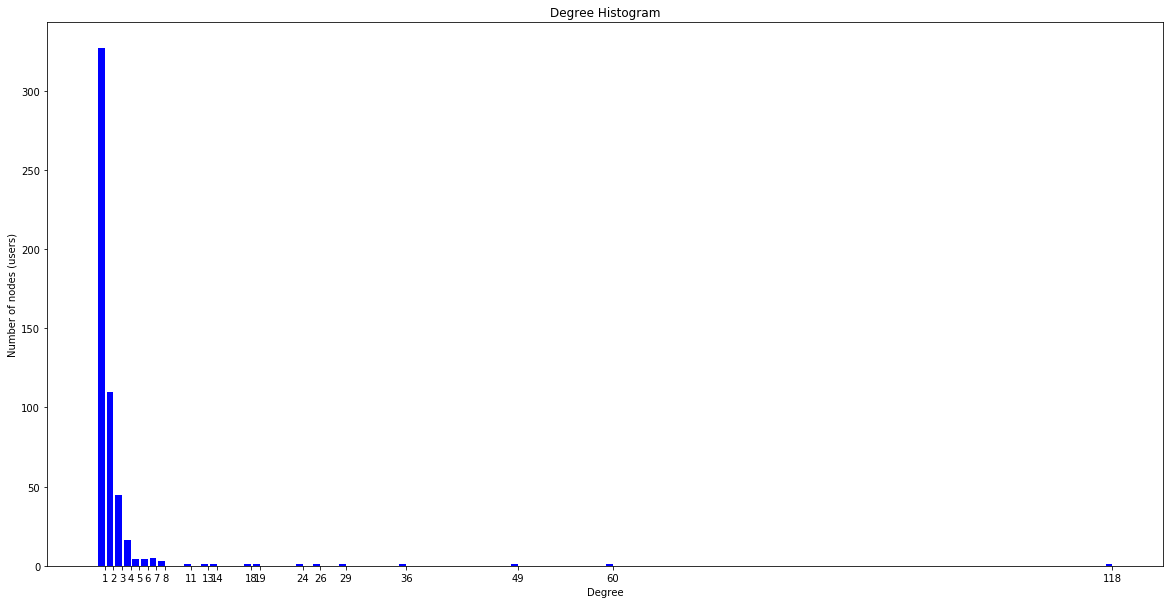

In [56]:
plot_hist(graph, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram')

In [ ]:
plot_hist(top100_Week0, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram (Top 100 Week 0)')
plot_hist(top100_Week1, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram (Top 100 Week 1)')
plot_hist(top100_Week2, xlabel='Degree', ylabel='Number of nodes (users)', title= 'Degree Histogram (Top 100 Week 2)')
plt.savefig('../output/top100_hist.png')

In [26]:
doc_topic_dist1

matrix([[2.10084647e-04, 9.99580622e-01, 2.09260732e-04],
        [4.72365379e-01, 2.21544094e-02, 5.05480230e-01],
        [3.98197353e-01, 3.92403007e-02, 5.62562346e-01],
        ...,
        [5.48456550e-01, 1.31303230e-02, 4.38413113e-01],
        [6.08217029e-04, 9.98776495e-01, 6.15209108e-04],
        [1.12034060e-04, 9.99774873e-01, 1.13092545e-04]], dtype=float32)

In [27]:
get_DT_row_norm(doc_topic_dist1)

matrix([[2.10084647e-04, 9.99580622e-01, 2.09260732e-04],
        [4.72365379e-01, 2.21544094e-02, 5.05480230e-01],
        [3.98197353e-01, 3.92403007e-02, 5.62562346e-01],
        ...,
        [5.48456550e-01, 1.31303230e-02, 4.38413113e-01],
        [6.08217088e-04, 9.98776615e-01, 6.15209166e-04],
        [1.12034060e-04, 9.99774873e-01, 1.13092545e-04]], dtype=float32)

In [28]:
get_DT_col_norm(doc_topic_dist1)

matrix([[2.01877882e-07, 2.22780881e-03, 3.08796587e-07],
        [4.53912857e-04, 4.93764928e-05, 7.45914294e-04],
        [3.82642145e-04, 8.74565594e-05, 8.30147823e-04],
        ...,
        [5.27031603e-04, 2.92641216e-05, 6.46946370e-04],
        [5.84457609e-07, 2.22601648e-03, 9.07836238e-07],
        [1.07657556e-07, 2.22824165e-03, 1.66885556e-07]], dtype=float32)

In [29]:
SAVE_DIR_1 = OUTPUT_DIR+'/df_p1_i50'
data = df
(TR1, TR_sum1, doc_topic_dist1, users1, top_users1) = twitter_rank(data=data, samples=2167, num_topics=3, 
                                                                   SAVE_DIR=OUTPUT_DIR+'/df_p1_i50')

samples: 2167, num_topics: 3
Dictionary and mm_corpus for the file:data_2167 already exists.. loading..
Num_topics: 3
Computing LDA model...
LDA model for the file:data_2167 already exists.. loading..
Finished computing LDA model...


In [30]:
TR1

matrix([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])

In [31]:
TR_sum1

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [57]:
a = 'asdasf'

In [59]:
list(a)

['a', 's', 'd', 'a', 's', 'f']

In [61]:
stack = [(3, 1)]
(node, depth) = stack.pop()

In [63]:
{1, 2}

{1, 2}

In [67]:
num=10
for i in [x for x in range(2, num+1) if x*x<=num]:
    print(i)

2
3


In [83]:
('-210')[:0:-1]

'012'

In [86]:
x = 1534236469
if x>=0 and x in range(-2**31, (2**31)-1):
        print(True)

True


In [89]:
print(2**31)
print(x)

2147483648
1534236469


In [90]:
'in' in 'inside'

True

In [91]:
x

1534236469

In [97]:
str(x)[:-1]

'153423646'

In [100]:
sorted(['flower', 'flow'])

['flow', 'flower']

In [101]:
102//10

10

In [103]:
102//100

1

In [105]:
for i in 'leetcode':
    print(i)

l
e
e
t
c
o
d
e


In [132]:
[0,1,0,3,12].remove(0)

In [137]:
def missingNumber(nums) -> int:
        return set(list(range(len(nums)+1))).difference(set(nums)).pop()

nums = [9,6,4,2,3,5,7,0,1,0,0]
print(missingNumber(nums))

8


In [138]:
nums.remove(0)
nums

[9, 6, 4, 2, 3, 5, 7, 1, 0, 0]

In [145]:
import collections
count_dict = collections.Counter([2,2,1,1,1,2,2])
for i,j in count_dict.items():
    print(i, j)

2 4
1 3


In [22]:
SAVE_DIR_1 = OUTPUT_DIR
TV_SHOW = 'Blackish'
data = df
(TR, TR_sum, doc_topic_dist, users, top_users) = twitter_rank(data=data, samples=945, TV_SHOW = TV_SHOW, 
                                                              num_topics=10, SAVE_DIR=SAVE_DIR_1)

samples: 945, num_topics: 10
Directory: ../models/Blackish/Blackish.dict
creating dictionary and mm_corpus for the Blackish samples..
Num_topics: 10
Computing LDA model...
creating lda model for the data_945 samples..
num_topics: 10
Finished computing LDA model...


In [23]:
TR

matrix([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])

In [24]:
TR_sum

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [26]:
samples = 945
DT_row_norm = get_DT_row_norm(doc_topic_dist)
DT_col_norm = get_DT_col_norm(doc_topic_dist)
trans_mat = get_Pt(DT_row_norm, data, samples, 0)
print(trans_mat)

[[9.75026196e-01 0.00000000e+00 3.58474000e-02 ... 0.00000000e+00
  1.21564887e-04 2.78671346e-04]
 [4.72701923e+02 0.00000000e+00 1.74234859e+01 ... 0.00000000e+00
  5.90520181e-02 1.35350734e-01]
 [5.15657899e+00 0.00000000e+00 6.00789214e-01 ... 0.00000000e+00
  9.09761177e-04 1.48491032e-03]
 ...
 [6.19424428e+02 0.00000000e+00 2.28663992e+01 ... 0.00000000e+00
  7.74725215e-02 1.77557381e-01]
 [2.29140193e+02 0.00000000e+00 1.19211049e+01 ... 0.00000000e+00
  3.77358491e-02 6.58721207e-02]
 [2.31995768e+03 0.00000000e+00 8.59377462e+01 ... 0.00000000e+00
  2.90935200e-01 6.66666667e-01]]


In [31]:
DT_row_norm

matrix([[7.3657793e-05, 3.2182911e-01, 7.3654177e-05, ..., 6.3793308e-01,
         3.9722309e-02, 7.3642463e-05],
        [9.9024584e-04, 9.9033536e-04, 9.9023979e-04, ..., 9.9108803e-01,
         9.9025678e-04, 9.9014700e-04],
        [4.3832704e-01, 3.2880649e-05, 3.2886161e-05, ..., 5.6140989e-01,
         3.2879216e-05, 3.2874603e-05],
        ...,
        [1.5388461e-03, 1.5388026e-03, 1.5387535e-03, ..., 9.8615134e-01,
         1.5387206e-03, 1.5390072e-03],
        [1.2997298e-01, 5.7159975e-04, 5.7156518e-04, ..., 5.7161012e-04,
         8.6545473e-01, 5.7144777e-04],
        [2.7785792e-03, 6.2613660e-01, 2.7785783e-03, ..., 2.7785155e-03,
         2.7788393e-03, 2.7778458e-03]], dtype=float32)

In [27]:
k=0
Et = DT_col_norm[:,k]
Et

matrix([[8.90508716e-07],
        [1.19718843e-05],
        [5.29929064e-03],
        [6.68112398e-06],
        [7.03039677e-06],
        [8.28224438e-06],
        [2.83146161e-03],
        [2.76069500e-06],
        [3.92614265e-06],
        [1.42261679e-05],
        [3.35866680e-05],
        [1.20924242e-05],
        [2.28150784e-05],
        [1.10932087e-05],
        [1.63408895e-05],
        [1.28648462e-05],
        [5.75829108e-06],
        [8.95760786e-06],
        [1.76024923e-06],
        [6.91014930e-06],
        [8.33960348e-06],
        [2.26046041e-06],
        [2.91392485e-06],
        [2.19855283e-05],
        [2.71521718e-03],
        [1.95038610e-05],
        [4.91579340e-06],
        [1.10939354e-05],
        [1.10944420e-05],
        [2.28133449e-05],
        [2.32532420e-05],
        [1.18551879e-05],
        [6.16949319e-06],
        [1.11964346e-05],
        [2.57281699e-05],
        [9.44708790e-06],
        [1.70314524e-05],
        [2.88609067e-06],
        [1.2

In [28]:
iter = 100
gamma=0.2
tolerance=1e-16
TRt = Et
old_TRt = TRt
i = 0
# np.linalg.norm(old_TRt,new_TRt)
while i < iter:
    TRt = (gamma*np.dot(trans_mat,old_TRt)) + ((1 - gamma) * Et)
    #print(TRt)
    euclidean_dis = np.linalg.norm(TRt - old_TRt)
    print(euclidean_dis,'\n')
    if euclidean_dis < tolerance:
        break
    old_TRt = TRt
    i += 1
 

13.425486641048268 

670.979683672645 

35066.80540714413 

1829011.2607526835 

95370759.8792067 

4972800023.990839 

259289757712.95172 

13519778703990.488 

704942653140784.8 

3.6756825185111896e+16 

1.9165590153165087e+18 

9.993241909605335e+19 

5.210634426874927e+21 

2.7169072235132143e+23 

1.4166384083876377e+25 

7.386576776530434e+26 

3.851477988492384e+28 

2.008221554397624e+30 

1.0471184889533437e+32 

5.459841457765957e+33 

2.8468477119276725e+35 

1.484391434732982e+37 

7.739851774567356e+38 

4.035681161354143e+40 

2.1042680028609622e+42 

1.09719862665729e+44 

5.72096721853821e+45 

2.983002814659179e+47 

1.5553848592997585e+49 

8.11002272156869e+50 

4.2286941493034394e+52 

2.2049080282840836e+54 

1.1496739280594277e+56 

5.9945817417528044e+57 

3.1256697557029897e+59 

1.629773659381232e+61 

8.497897693659256e+62 

4.430938296015688e+64 

2.3103613259250956e+66 

1.2046589457429599e+68 

6.281282322701021e+69 

3.2751599742733167e+71 

1.70772022431

In [42]:
from collections import Counter
list = [1,2,3,4,1,2,6,7,3,8,1]  
cnt = Counter(list)  
print(cnt)

Counter({1: 3, 2: 2, 3: 2, 4: 1, 6: 1, 7: 1, 8: 1})
